In [2]:
!pip install spafe
from spafe.fbanks import linear_fbanks, mel_fbanks, gammatone_fbanks
import librosa
import numpy as np
from matplotlib import pyplot as plt

Współczynniki mel-cepstralne (MFCC - *mel frequency cepstral coefficients*) są stosowane szczególnie w analizie mowy. Poniżej krótkie omówienie tej metody analizy sygnału - szersze wyjaśnienie można znaleźć np. w materiałach [Aalto University](https://speechprocessingbook.aalto.fi/Representations/Melcepstrum.html) lub [Politechniki Gdańskiej](https://sound.eti.pg.gda.pl/student/amowy/AM_05_parametryzacja.pdf) (slajdy 38-41 i 68-71).

# Cepstrum

Wyjaśnijmy posczególny elementy MFCC. Współczynniki mel-*cepstralne*. Czym jest cepstrum?

Z widma sygnału uzyskanego przez STFT możemy zrekonstruować sygnał, wykonując odwrotną transformatę (ISTFT). 

Co gdybyśmy spróbowali poddać transformacji spektrogram (czyli zlogarytmowane wartości amplitudy), a do tego nie zmieniali jądra (czyli wykonali po raz kolejny transformację częstotliwościową)? Przechodzimy do dziedziny, która jest wyrażona w jednostkach czasu, ale nim nie jest - są to tzw. pseudo-częstotliwości (*quefrency*), a otrzymana postać sygnału nazywana jest *cepstrum* (anagram *spectrum*).

Wartości cepstrum związane są z autokorelacją występującą w sygnale, dzięki czemu można je wykorzystać np. do wyznaczania tonu podstawowego ($F_0$) w sygnale mowy.

# Percepcyjne skale częstotliwości

Skoro *mel*-capstralne, to wyjaśnijmy jeszcze, czym są mele. W związku z nieliniowym postrzeganiem częstotliwości przez człowieka, stosuje się skale, które w założeniu mają lepiej odzwierciedlać działanie ludzkiego układu słuchowego. Jedną z nich jest skala melowa. Filtry melowe mają kształt trójkątów i obejmują coraz szersze pasmo wraz ze wzrostem częstotliwości - podobnie jak rozdzielczość naszego słuchu jest największa w niskich częstotliwościach.

Podobne do filtrów melowych są filtry gammatone/ERB (*equivalent rectangular bandwidth*), które mają bardziej zaokrąglony kształt, symlujący odpowiedź błony podstawnej na drgania.

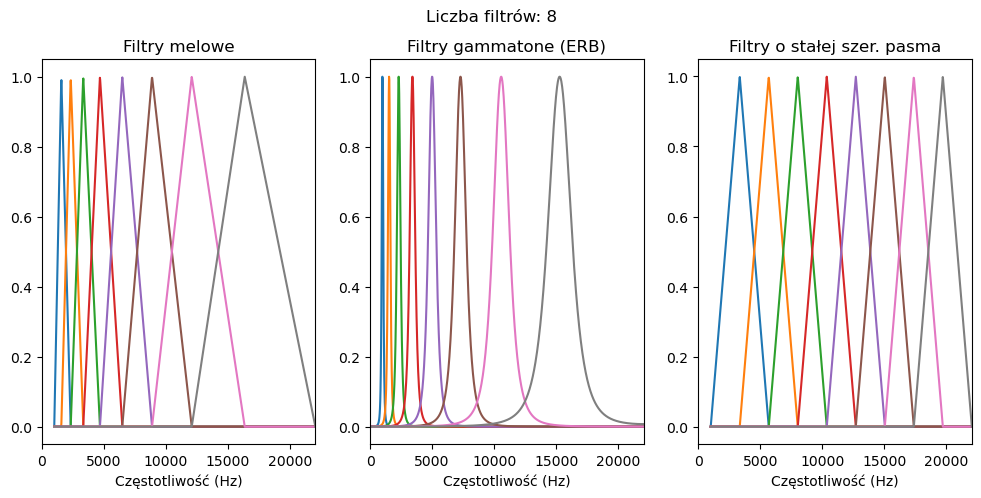

In [5]:
fs = 44100
nfft = 2048

n_filters = 8
fmin = 1000
fmax = fs/2

constant_bw = linear_fbanks.linear_filter_banks(nfilts=n_filters, nfft=nfft, fs=fs, low_freq=fmin, high_freq=fmax)[0].T
mel_filters = mel_fbanks.mel_filter_banks(nfilts=n_filters, nfft=nfft, fs=fs, low_freq=fmin, high_freq=fmax)[0].T
gamma_filters = gammatone_fbanks.gammatone_filter_banks(nfilts=n_filters, nfft=nfft, fs=fs, low_freq=fmin, high_freq=fmax)[0].T

f_g = np.linspace(0, fs/2, nfft//2+1)
f_l = np.linspace(fmin, fmax, nfft//2+1)

fig, ax = plt.subplots(1, 3, figsize=(12, 5))

ax[0].plot(f_l, mel_filters)
ax[0].set(xlabel='Częstotliwość (Hz)', title='Filtry melowe', xlim=(0, fs/2))
ax[1].plot(f_g, gamma_filters)
ax[1].set(xlabel='Częstotliwość (Hz)', title='Filtry gammatone (ERB)', xlim=(0, fs/2))
ax[2].plot(f_l, constant_bw)
ax[2].set(xlabel='Częstotliwość (Hz)', title='Filtry o stałej szer. pasma', xlim=(0, fs/2))
fig.suptitle(f'Liczba filtrów: {n_filters}');

# Melspektrogram

Wykonując analizę czasowo-częstotliwościową możemy zamiast filtrów o równej szerokości, które daje nam transformata Fouriera, wykorzystać filtry melowe - otrzymujemy wówczas melspektrogram.

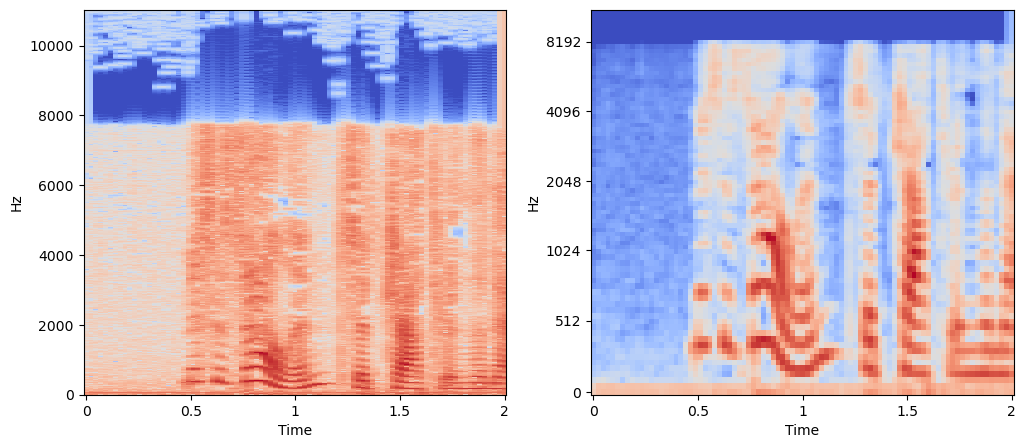

In [13]:
data, fs = librosa.load(librosa.ex('libri3')) #ładujemy przykładowy plik z biblioteki: https://librosa.org/doc/main/recordings.html
data = data[:fs*2]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
f, t, S = librosa.reassigned_spectrogram(data, hop_length=512)
librosa.display.specshow(librosa.power_to_db(S), sr=fs, x_axis='time', y_axis='hz', ax=ax[0])
librosa.display.specshow(librosa.power_to_db(librosa.feature.melspectrogram(y=data, sr=fs, n_mels=80)), sr=fs, x_axis='time', y_axis='mel', ax=ax[1]);

# MFCC

## Algorytm wyznaczania
wygląda więc następująco:
1. Pre-emfaza, czyli usuwanie składowej stałej i poprawa rozkładu energii.
2. Analiza czasowo-częstotliwościowa:

    a) Okienkowanie sygnału (najczęściej: okno Hamminga lub Hanninga o długości 20 ms, nakładkowanie 10 ms);

    b) DFT (dyskretna transformata Fouriera).
    
3. Przejście na skalę melową - tutaj wybieramy liczbę *k* filtrów, których chcemy użyć (= ile współczynników uzyskać).
4. Logarytm amplitudy - uzyskanie melspektrogramu.
4. DCT (dyskretna transformacja kosinusowa), przejście do dziedziny pseudo-częstotliwości. Dla każdej ramki sygnału dostajemy zestaw *k* współczynników melcepstralnych.

# GFCC

W analogiczny sposób możemy wyznaczyć współczynniki GFCC (*gammatone-frequency cepstral coefficients*) - wtedy zamiast filtrów melowych korzystamy z ERB (gammatone). Jest to jednak mniej popularna metoda.